In [46]:
# Импортируем библеотеки
import numpy as np
import pandas as pd
import pickle

from funcs import *
from matplotlib import pyplot as plt

In [9]:
# Загружам БД
encoded = pd.read_excel('encoded.xlsx').drop('Nanoparticle', axis=1)
encoded.head()

,Electronegativity,Diameter (nm),Zeta_in_Water (mV),Concentration (ug/mL),Molecular weight (g/mol),Density (g/cm3),Viability (%),is_inorganic,Cell_Age,coat,...,Cell_Morphology,Test_Indicator,Time (hr),Test,Cell line (L)/primary cells (P),Zeta_in_Medium (mV),Cell_Tissue,Size_in_Medium (nm),Size_in_Water (nm),Surface area (um2)
0,1.90,313.8,7.6,2.30103,79.5450,5.94,9.1,1,0,77,...,2,18,24,19,0,42.80,21,239.0,276.4,0.092516
1,1.65,114.7,28.8,2.30103,81.3800,5.44,9.5,1,0,77,...,2,18,24,19,0,-11.70,24,273.4,243.7,-0.781663
2,1.65,114.7,28.8,2.00000,81.3800,5.44,10.2,1,0,77,...,2,18,24,19,0,-11.70,24,273.4,243.7,-0.781663
3,1.65,69.4,28.8,2.00000,81.3800,5.44,11.0,1,0,77,...,2,18,24,19,0,-11.70,24,273.4,243.7,-1.218071
4,1.55,291.7,-46.1,2.30103,157.8743,4.59,11.3,1,0,77,...,2,18,24,19,0,-23.76,24,206.7,243.7,0.029083


In [10]:
# Перемешиваем датасет
encoded = encoded.sample(frac=1)
encoded.reset_index(drop=True, inplace=True)

In [55]:
# Скалируем данные
from sklearn.preprocessing import MinMaxScaler

scaled, scalers = scale_by_columns(encoded, MinMaxScaler)

In [56]:
# Сохраняем инструменты скейлинга
with open('scalers.bf', 'wb') as f:
    pickle.dump(scalers, f)

In [12]:
# Импортируем кучу моделей и вспомогательные
# инструменты
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [13]:
# Соревнование моделей
winner = get_winner_model([
    RandomForestRegressor, DecisionTreeRegressor,
    CatBoostRegressor
], scaled, 'Viability (%)', 'Viability (%)')

SHUFFLING: 0


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.055585
0:	learn: 0.1537346	total: 2.18ms	remaining: 2.18s
1:	learn: 0.1516316	total: 4.11ms	remaining: 2.05s
2:	learn: 0.1497292	total: 6.32ms	remaining: 2.1s
3:	learn: 0.1478454	total: 8.47ms	remaining: 2.11s
4:	learn: 0.1461103	total: 10.4ms	remaining: 2.06s
5:	learn: 0.1447132	total: 12.3ms	remaining: 2.04s
6:	learn: 0.1432309	total: 14.3ms	remaining: 2.03s
7:	learn: 0.1419598	total: 16.3ms	remaining: 2.02s
8:	learn: 0.1407445	total: 18.1ms	remaining: 2s
9:	learn: 0.1396043	total: 20.1ms	remaining: 1.99s
10:	learn: 0.1385114	total: 22ms	remaining: 1.98s
11:	learn: 0.1373989	total: 24.1ms	remaining: 1.98s
12:	learn: 0.1364023	total: 25.8ms	remaining: 1.96s
13:	learn: 0.1353821	total: 27.7ms	remaining: 1.95s
14:	learn: 0.1345382	total: 29.6ms	remaining: 1.94s
15:	learn: 0.1339608	total: 31.3ms	remaining: 1.93s
16:	learn: 0.1331120	total: 33.2ms	remaining: 1.92s
17:	learn: 0.1323804	total: 35ms	remaining: 1.91s
18:	learn: 0.1316885	total: 36.8ms	remaining: 1.9s
1

In [14]:
# Победитель
winner

sklearn.ensemble._forest.RandomForestRegressor

In [50]:
# Деление данных
x, y = scaled.drop('Viability (%)', axis=1), scaled['Viability (%)']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.18)

In [16]:
# Проба модели
rfr = RandomForestRegressor().fit(x_train, y_train)
rfr.score(x_test, y_test)

0.7624319546040634

In [17]:
# Подбор параметров для модели
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(
    RandomForestRegressor(), {
        'n_estimators': [100, 200, 300],
        'min_samples_split': [1, 2, 3, 4],
        'max_depth': [16, 30, 100]
    }, cv=5, n_jobs=2
).fit(x_train, y_train)

d:\python\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.73839159 0.73990039 0.74172396
 0.73497995 0.73753788 0.73803709 0.73541597 0.73530888 0.73509461
        nan        nan        nan 0.74365807 0.74735763 0.74701227
 0.74369752 0.74363826 0.74473868 0.74103988 0.74195302 0.74285082
        nan        nan        nan 0.74727892 0.74532968 0.74629247
 0.74239124 0.74439742 0.74529618 0.74211454 0.74149731 0.7418252 ]
  warnings.warn(


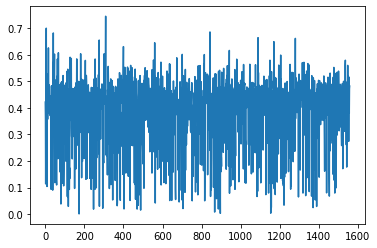

In [18]:
# Проверяем, что модель не предсказывает
# одни и те же значения
plt.plot(search.predict(x_test))

In [19]:
# Просмотри конфигурации
rfr = search.best_estimator_
rfr

RandomForestRegressor(max_depth=30, n_estimators=200)

In [20]:
# Тестирование
rfr.score(x_test, y_test)

0.7642828551008254

In [22]:
# Кросс-валидация
cross_val_score(
    RandomForestRegressor(max_depth=30, n_estimators=200),
    x, y, cv=5
)

array([0.79418647, 0.7439049 , 0.7859334 , 0.80022954, 0.71946423])

In [51]:
# Теперь обучаем модель на всех данных для большей точности
rfr = RandomForestRegressor(max_depth=30, n_estimators=200).fit(x, y)

<BarContainer object of 20 artists>

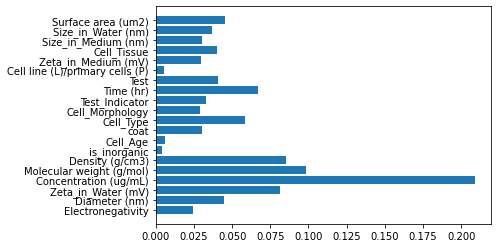

In [52]:
# Интерпретация модели
plt.barh(x.columns, rfr.feature_importances_)

In [53]:
# Сохранение модели
import joblib

joblib.dump(rfr, "model.joblib")

['model.joblib']

In [54]:
# Было решено попробовать решить задачу с помощью НС.

In [29]:
# Загрузка кодировщиков
with open('encoders.bf', 'rb') as f:
    encoders = pickle.load(f)

In [30]:
# Подготовка инструментов для one-hot кодирования
categorical = list(encoders.keys())
categorical

['Cell_Age',
 'coat',
 'Cell_Type',
 'Cell_Morphology',
 'Test_Indicator',
 'Test',
 'Cell line (L)/primary cells (P)',
 'Cell_Tissue']

In [31]:
cat_max = get_cat_max(encoded, categorical)

with open('cat_max.bf', 'wb') as f:
    pickle.dump(cat_max, f)

In [32]:
# Подготовка данных для НС
x, y = encoded.drop('Viability (%)', axis=1), encoded['Viability (%)'].values

x = np.array([
    row_to_array(row, cat_max) for row in x.iloc
])

x.shape, y.shape

((8656, 358), (8656,))

In [33]:
# Скейлинг данных
scalers = []

for i in range(x.shape[1]):
    reshaped = x[:, i].reshape(-1, 1)
    scaler = MinMaxScaler().fit(reshaped)
    x[:, i] = scaler.transform(reshaped).reshape(-1)
    scalers.append(scaler)

reshaped = y.reshape(-1, 1)
scaler = MinMaxScaler().fit(reshaped)
y = scaler.transform(reshaped).reshape(-1)
scalers.append(scaler)

In [34]:
# Импорт Tensorflow
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

In [35]:
# Функция для создания модели
def make_model():
    model = Sequential([
        Dense(256, activation='relu'),
        Dense(512, activation='relu'),
        Dense(128, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(
        optimizer='adam',
        loss='mse'
    )
    return model

In [36]:
# Кросс-валидация
unit = len(x) // 5

best_model = None
x_trains = []
x_tests = []

for i in range(5):
    print('FOLD', i)
    test_start = unit * i
    test_end = unit * (i + 1)
    x_test = x[test_start:test_end]
    y_test = y[test_start:test_end]
    x_train = np.concatenate([
        x[:test_start], x[test_end:]
    ])
    y_train = np.concatenate([
        y[:test_start], y[test_end:]
    ])
    model = make_model()
    model.fit(x_train, y_train, batch_size=45, epochs=64, verbose=0)
    loss = model.evaluate(x_test, y_test)
    if best_model is None or best_model[0] > loss:
        best_model = (loss, model, i)
    x_trains.append(x_train)
    x_tests.append(x_test)

FOLD 0
55/55 [==============================] - 0s 2ms/step - loss: 0.0063
FOLD 1
55/55 [==============================] - 0s 2ms/step - loss: 0.0068
FOLD 2
55/55 [==============================] - 0s 2ms/step - loss: 0.0066
FOLD 3
55/55 [==============================] - 0s 3ms/step - loss: 0.0071
FOLD 4
55/55 [==============================] - 0s 2ms/step - loss: 0.0086


In [37]:
# Модель, имеющая наибольший test-score
best_model

(0.0063108401373028755,
 0)

In [38]:
# Погрешность
scalers[-1].inverse_transform([[0.0063 ** 0.5]])

array([[16.61324773]])

In [39]:
model = best_model[1]

In [40]:
x_train = x_trains[best_model[2]]
x_test = x_tests[best_model[2]]

In [41]:
# Подготовка колонок для визуализации
cols = []

for col in encoded.columns:
    if col == 'Viability (%)':
        continue
    elif col not in cat_max:
        cols.append(col)
        continue
    cols += [col] * (cat_max[col] + 1)

In [42]:
# Визуализация
import shap

explainer = shap.DeepExplainer(model, x_train)
shap_values = explainer.shap_values(x_test)

array([[0.90630048, 0.01831502, 0.3005    , ..., 0.18533358, 0.07170157,
        0.43513806],
       [0.96833603, 0.03800366, 0.273     , ..., 0.75775727, 0.1612853 ,
        0.53589749],
       [0.87560582, 0.08012821, 0.46      , ..., 0.16248423, 0.42138941,
        0.64073269],
       ...,
       [0.75848142, 0.00595238, 0.46      , ..., 0.0504193 , 0.04906352,
        0.28797981],
       [0.94701131, 0.03543956, 0.557     , ..., 0.07148354, 0.13482524,
        0.52615675],
       [0.69063005, 1.        , 0.608     , ..., 0.21540268, 0.42138941,
        1.        ]])>]. Consider rewriting this model with the Functional API.


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


array([[2.90791599e-01, 3.20512821e-03, 5.29000000e-01, ...,
        4.76028022e-04, 6.67554433e-03, 2.14970111e-01],
       [9.68336026e-01, 3.28754579e-01, 7.35000000e-01, ...,
        1.62484232e-01, 2.83554987e-01, 8.41270828e-01],
       [9.06300485e-01, 5.03663004e-03, 9.40000000e-01, ...,
        1.62484232e-01, 1.37661484e-02, 2.67527138e-01],
       ...,
       [9.06300485e-01, 1.55677656e-02, 3.77400000e-01, ...,
        1.62484232e-01, 7.17015720e-02, 4.13106094e-01],
       [9.70920840e-01, 1.13461538e-01, 4.12000000e-01, ...,
        1.34477916e-01, 2.15934836e-01, 6.89971871e-01],
       [9.68336026e-01, 9.06593407e-03, 2.73000000e-01, ...,
        1.59310711e-01, 2.84419695e-01, 3.41413682e-01]])>]. Consider rewriting this model with the Functional API.


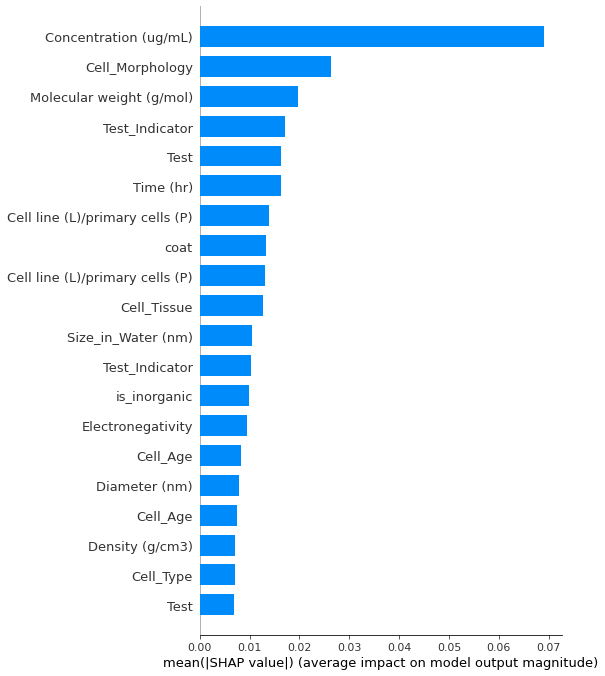

In [43]:
shap.summary_plot(shap_values[0], plot_type='bar', feature_names=cols)

In [44]:
# Сохранение модели
model.save('model')

INFO:tensorflow:Assets written to: model\assets
